# Simple retirement analysis

The goal of this notebook is to get a baseline for how much I need to be saving to provide a comfortable retirement.  I would like to aim for retirement by 60, both for a simple number and a conservative estimate in case I'm not prepared by then.

## Imports

In [108]:
import math
import matplotlib.pyplot as pyplot

Matplotlib is building the font cache; this may take a moment.


## Expected required income

### Assumptions for the increased cost of living in 30 years

I'm performing a pretty naive analysis based on wage growth 30 years ago vs. today.  A Google search suggests that the median income in 1995 was $34,000, whereas in 2025 it's stated as $62,000.  The household median income in 1995 was $34,000 as welll (suspiciously), whereas in 2025 it's $84,000.  The _average_ household income in 1995 was $45,000, whereas that figure is $121,000 in 2025.  The ratios are evaluated below.

In [109]:
median_individual_scale = 62/34
print("2025/1995 median income: ", median_individual_scale)
median_household_scale = 84/34
print("2025/1995 median household income: ", median_household_scale)
mean_household_scale = 121/45
print("2025/1995 mean household income: ", mean_household_scale)

2025/1995 median income:  1.8235294117647058
2025/1995 median household income:  2.4705882352941178
2025/1995 mean household income:  2.688888888888889


This provides a range of income multipliers for retirement age as roughly 1.8-2.7 times expected required income in present-day dollars.

### Assumptions for retiree expenses

#### Cost-based estimate

I'm thinking _optimistically_ that household expenses might be similar to how they are now with the savings included as expenses.  Using convenient estimates, my rough monthly expenses include the following.
- $2,000 rent
- $600 in groceries
- $1,200 in savings
- $400 in misc
I.e., around $4,200/month.  I'm sure Hailey's got additional expenses I'm missing, so let's bump things up to an even $5,000/month, or $60,000/year.  Notably this is after tax, and this already feels quite low, so I'm going to say we need to aim for **$100,000** in taxable income for retirement (assuming my roth IRA doesn't dominate my eventual retirement accounts).

#### Present-day income-based estimate

Because $100,000/year in present-day dollars feels low for a 60 year old couple, I'm going to also consider our current household income as another baseline.  [_Note: I do think you accumulate assets by your 60s--cars, home, furniture, etc.--so this may not be as crazy as it sounds if costs are mostly maintenance vs. big purchases._]  To pick an even number, I'll put the mark at **$250,000**.

### Summary

I'm starting with two kinds of baseline estimates for required income in retirement using 2025 dollars, and then use a range of scale factors to approximate my income requirements in 2055 dollars.

#### Estimates in 2025 dollars

In [110]:
cost_estimate = 100_000
print("Income estimate in 2025 dollars based on cost: ", cost_estimate)
household_estimate = 250_000
print("Income estimate in 2025 dollars based on current income: ", household_estimate)

Income estimate in 2025 dollars based on cost:  100000
Income estimate in 2025 dollars based on current income:  250000


#### Cost-based projections in 2055 dollars

In [111]:
print("Scaled by median individual income: ",
      median_individual_scale * cost_estimate)
print("Scaled by median household income: ",
      median_household_scale * cost_estimate)
print("Scaled by mean household income: ",
      mean_household_scale * cost_estimate)

Scaled by median individual income:  182352.94117647057
Scaled by median household income:  247058.82352941178
Scaled by mean household income:  268888.88888888893


#### Present-day-based projections in 2055 dollars

In [112]:
print("Scaled by median individual income: ",
      median_individual_scale * household_estimate)
print("Scaled by median household income: ",
      median_household_scale * household_estimate)
print("Scaled by mean household income: ",
      mean_household_scale * household_estimate)

Scaled by median individual income:  455882.35294117645
Scaled by median household income:  617647.0588235294
Scaled by mean household income:  672222.2222222222


## Expected required future savings

### Estimated investment returns

A google search shows many resources claiming a 5-7% _inflation-adjusted_ annual return is typical in a 401k portfolio.  The "inflation adjustment" seems to boil down to subtracting 3% from expected actual returns, so I will be factoring this 3% back in.

I.e., I'm considering **8%-10%** returns and will factor inflation separately using the historical income ratios.

In [113]:
rate_low = 0.08
print("Lower estimated annual rate of return: ", rate_low)
rate_high = 0.1
print("Higher estimated annnual rate of return: ", rate_high)

Lower estimated annual rate of return:  0.08
Higher estimated annnual rate of return:  0.1


### Withdrawal assumptions

I'm assuming that the ideal retirement scenario is where expected expenses are commensurate with typical investment returns after taking inflation into account.

#### Income inflation rates implied by 2025/2055 analysis

The rate of income inflation (compounded annually), $r_{I}$, can be determined by the compound interest formula applied to the income ratios,  
$r_I = \left(\frac{I_{2055}}{I_{2025}}\right)^{1/12} - 1\quad .$  

The rates for the income ratios under consideration are provided below.

In [114]:
def annual_rate(future_over_past: float, years: int) -> float:
    """
    ### Calculates implied annual compounding rate from an input ratio and duration
    - future_over_past - ratio of the underlying value at the end of the duration divided by the underlying value at the start of the duration
    - years - the (integer) number of months that have passed between the values used in the ratio
    """
    return math.pow(future_over_past, 1/years) - 1

In [115]:
median_individual_rate = annual_rate(median_individual_scale, 30)
print("median individual rate (annual compounding): ", median_individual_rate)
median_household_rate = annual_rate(median_household_scale, 30)
print("median household rate (annual compounding): ", median_household_rate)
mean_household_rate = annual_rate(mean_household_scale, 30)
print("mean household rate (annual compounding): ", mean_household_rate)

median individual rate (annual compounding):  0.02022765681439931
median household rate (annual compounding):  0.030607611588564287
mean household rate (annual compounding):  0.03352049973216076


## Data organization through the ExpenseParameters class

The basic ingredients are all here, but I want to collect these terms into a more usable format.

In [116]:
class ExpenseParameters:
    """
    ### ExpenseParameters is essentially a dataclass, but uses a custom constructor to hide some calculations.
    - future_annual_expenses - the expected annual expenses at savings maturity
    - growth_rate - the typical annual expected return on the savings
    - income_inflation_rate - the typical inflation rate expected (used both up to and through the maturity date)
    """
    required_savings_at_maturity: float
    growth_rate: float

    def __init__(self, present_annual_expenses: float, growth_rate: float, income_inflation_rate: float, years: int):
        future_annual_expenses = present_annual_expenses * math.pow(1 + income_inflation_rate, years)
        withdrawal_rate = growth_rate - income_inflation_rate
        self.required_savings_at_maturity = future_annual_expenses / withdrawal_rate
        self.growth_rate = growth_rate

### The list of parameters currently in use

In [117]:
expense_parameters = []

# All the currently-enumerated parameters
expenses = {"cost estimate": cost_estimate, "household estimate": household_estimate}
rates = {"low rate": rate_low, "high rate": rate_high}
income_rates = {
    "median individual": median_individual_rate,
    "median household": median_household_rate,
    "mean household": mean_household_rate
}

for rate_name, rate in rates.items():
    for expense_name, expense in expenses.items():
        for income_name, income_rate in income_rates.items():
            parameters = ExpenseParameters(expense, rate, income_rate, 30)
            print("For the", expense_name, "at", rate_name, "and using the", income_name,"as a baseline, total required at 2055: ", parameters.required_savings_at_maturity)
            expense_parameters.append(parameters)
print("")
print(len(expense_parameters), "total savings scenarios under consideration")

For the cost estimate at low rate and using the median individual as a baseline, total required at 2055:  3050791.2432049327
For the cost estimate at low rate and using the median household as a baseline, total required at 2055:  5001961.465629596
For the cost estimate at low rate and using the mean household as a baseline, total required at 2055:  5785107.140554646
For the household estimate at low rate and using the median individual as a baseline, total required at 2055:  7626978.108012332
For the household estimate at low rate and using the median household as a baseline, total required at 2055:  12504903.664073993
For the household estimate at low rate and using the mean household as a baseline, total required at 2055:  14462767.851386618
For the cost estimate at high rate and using the median individual as a baseline, total required at 2055:  2285916.8214753685
For the cost estimate at high rate and using the median household as a baseline, total required at 2055:  3560315.896097

## Expected savings rate based on future expenses

### The compounding analysis

For now, I'm going to consider a constant rate of savings to simplify the math.  This is definitely an over-simplification, but I think it still has utility so long as I can tune the following.
- the period of investment
- the principal
- the target amount at retirement (investment maturity)
- the expected typical rate of return (input _per annum_, but internally compounded _monthly_)

The value $V$ of an investment with principal $P$ over the period $T$ (in years) can be related to the (currently constant) savings rate $s$ (in $/month),  
$V = P \left(1 + \frac{r_M}{12}\right)^{12T}+ \sum_{i=1}^{12 T} s \left(1+\frac{r_M}{12}\right)^{i} \quad ,$  
where $r_M$ is the rate of return compounded monthly, determined from the typical rate of return _per annum_ $r$ via  
$r_M = 12\left[\left(1 + r\right)^{1/12} - 1\right] \quad .$  
Notably, this assumes that we can ignore edge effects by rounding $T$ to an integer number of years.[^At the time of writing, I'm taking the floor of $T$ as the integral number of years.]  

### The future value predicted by savings rate and principal

Since it's a useful calculation to have on-hand, this function calculates the future value vased on a savings rate, investment period, and expected rate of return _per annum_.

####

In [118]:
def annual_rate_to_monthly(annual_rate: float) -> float:
    """
    ### Converts an annual compounding rate to the monthly compounding rate
    - annual_rate - the rate of return when compounded annually
    """
    return 12 * (math.pow(1 + annual_rate, 1/12) - 1)

def future_value(principal: float, period: int, annual_rate: float, savings_rate: float) -> float:
    """
    ### Calculates the future value (in dollars) of a savings investment strategy.  
    - principal - initial investment in dollars  
    - period - number of years to predict to the value of this investment  
    - annual_rate - the expected rate of return per year  
    - savings_rate - the monthly contribution to the investment in dollars
    """
    monthly_rate = annual_rate_to_monthly(annual_rate)
    compounding_factor = 1 + monthly_rate / 12
    future_principal = principal * math.pow(compounding_factor, 12 * period)
    future_savings = savings_rate * sum(math.pow(compounding_factor, i) for i in range(1, 12 * period + 1))
    return future_principal + future_savings

### The required savings rate for a desired future value

Because I've assumed a constant rate of savings $s$, backing out the implied savings rate for a fixed principal $P$ and desired future value $V$ is simple algebra.  
#### $s = \frac{V - P\left(1 + \frac{r_M}{12}\right)^{12T}}{\sum_{i=1}^{12 T} \left(1+\frac{r_M}{12}\right)^{i}} \quad$

In [119]:
def required_monthly_savings(future_value: float, principal: float, period: int, annual_rate: float) -> float:
    """
    ### Calculates the required monthly savings rate (in dollars) to achieve the desired future value (in dollars).
    - future_value - the desired future value in dollars
    - principal - the initial investment in dollars
    - period - the number of years where the savings rate is contributed monthly
    - annual_rate - the expected rate of return per year
    """
    monthly_rate = annual_rate_to_monthly(annual_rate)
    compounding_factor = 1 + monthly_rate / 12
    future_principal = principal * math.pow(compounding_factor, 12 * period)
    future_savings_factor = sum(math.pow(compounding_factor, i) for i in range(1, 12 * period + 1))
    return (future_value - future_principal) / future_savings_factor

### The required savings rate for each of the considered retirement goals

#### Estimated current principal

Separating out savings for near-term expenses (car, business, home, etc.), let's estimate my current investment savings at $90,000.  

In [120]:
current_principal = 90_000
print("Current principal: ", current_principal)

Current principal:  90000


#### Estimated savings rate based on current principal

In [121]:
period = 30  # years

# Save pairs of [ExpenseParameters, savings_rate]
savings_parameters = []

for parameters in expense_parameters:
    savings_rate = required_monthly_savings(
        parameters.required_savings_at_maturity, 
        90000,
        period,
        parameters.growth_rate
    )
    print("2055 savings of", parameters.required_savings_at_maturity, ", compounding at", parameters.growth_rate, "with", current_principal, "current principal requires saving", savings_rate, "per month")
    savings_parameters.append([parameters, savings_rate])

2055 savings of 3050791.2432049327 , compounding at 0.08 with 90000 current principal requires saving 1513.2139405687774 per month
2055 savings of 5001961.465629596 , compounding at 0.08 with 90000 current principal requires saving 2889.590911264607 per month
2055 savings of 5785107.140554646 , compounding at 0.08 with 90000 current principal requires saving 3442.030498174354 per month
2055 savings of 7626978.108012332 , compounding at 0.08 with 90000 current principal requires saving 4741.306570280302 per month
2055 savings of 12504903.664073993 , compounding at 0.08 with 90000 current principal requires saving 8182.248997019878 per month
2055 savings of 14462767.851386618 , compounding at 0.08 with 90000 current principal requires saving 9563.347964294246 per month
2055 savings of 2285916.8214753685 , compounding at 0.1 with 90000 current principal requires saving 344.09326386219766 per month
2055 savings of 3560315.8960975683 , compounding at 0.1 with 90000 current principal require

#### Sorted output

In [ ]:
sorted_savings = sorted(savings_parameters, key=lambda savings: savings[1])
for parameters, savings in sorted_savings:
    print("2055 savings of", parameters.required_savings_at_maturity, ", compounding at", parameters.growth_rate, "with", current_principal, "current principal requires saving", savings, "per month")

2055 savings of 2285916.8214753685 , compounding at 0.1 with 90000 current principal requires saving 344.09326386219766 per month
2055 savings of 3560315.8960975683 , compounding at 0.1 with 90000 current principal requires saving 956.9935374185256 per month
2055 savings of 4044688.780835626 , compounding at 0.1 with 90000 current principal requires saving 1189.9443292630915 per month
2055 savings of 3050791.2432049327 , compounding at 0.08 with 90000 current principal requires saving 1513.2139405687774 per month
2055 savings of 5714792.053688422 , compounding at 0.1 with 90000 current principal requires saving 1993.1517178923157 per month
2055 savings of 5001961.465629596 , compounding at 0.08 with 90000 current principal requires saving 2889.590911264607 per month
2055 savings of 5785107.140554646 , compounding at 0.08 with 90000 current principal requires saving 3442.030498174354 per month
2055 savings of 8900789.740243921 , compounding at 0.1 with 90000 current principal requires s

### Plotted output

**WIP**: missing different rates (some are for 8%, some for 10% annual growth), so any two points are not necessarily comparable.  Should be clear which is which.

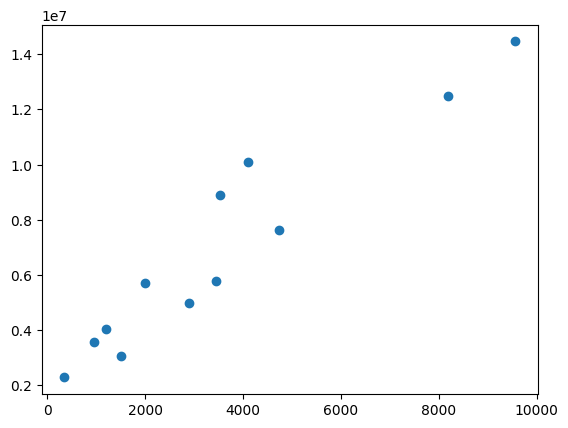

In [123]:
coords = [[parameters[1], parameters[0].required_savings_at_maturity] for parameters in sorted_savings]
pyplot.scatter([coord[0] for coord in coords], [coord[1] for coord in coords])

## Summary

As of [12/15/2025], it looks like I'll need around $4m-$6m in savings at retirement, which requires around $2,000-$4,000 in monthly investment savings.

## Issues